# Historical Data Model

In [79]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pprint
%load_ext autoreload
from scipy import stats
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error
from pylab import rcParams

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overview

This baseline model predicts available bikes by the hour by comparing a target date in 2016 to a predicted value generated by a function built on historical data from that month in 2015 for that day type (i.e. Monday, Sunday, etc.).

This model attempts to answer the question - how well can we predict the bikes available at a given day and time if we reference that day type in the previous year (for that same month). 

The days vary from each other, so I chose to average the hourly values within each day type (i.e. averaging the the hour 0 values across all Mondays for a given station). 

## Load data

In [2]:
status_2015 = pd.read_csv('~/Code/bikesupply/data/test_data/status_may15.csv', parse_dates = ['time'])
status_2016 = pd.read_csv('~/Code/bikesupply/data/test_data/status_may16.csv', parse_dates = ['time'])

## 2015

In [3]:
status_2015 = status_2015.set_index('time')
status_2015['hour'] = [ts.hour for ts in status_2015.index]
status_2015['weekday'] = [ts.weekday() for ts in status_2015.index]

In [76]:
means_2015 = status_2015.groupby(['weekday','station_id','hour']).mean()
median_2015 = status_2015.groupby(['weekday','station_id','hour']).median() # Experimented with median

## 2016

In [75]:
status_2016['hour'] = status_2016.time.dt.hour
status_2016['weekday'] = status_2016.time.dt.weekday
status_2016['day'] = status_2016.time.dt.day

In [77]:
means_2016 = status_2016.groupby(['day', 'weekday', 'station_id','hour']).mean()
median_2016 = status_2016.groupby(['day', 'weekday', 'station_id','hour']).median()

## Merge 2015 and 2016

In [12]:
means_2016[0:5]

bikes_available  docks_available
day weekday station_id hour                                  
1   6       2          0                13.0             14.0
                       1                13.0             14.0
                       2                13.0             14.0
                       3                13.0             14.0
                       4                13.0             14.0

In [13]:
means_2015[0:5]

Unnamed: 0  bikes_available  docks_available  month
weekday station_id hour                                                     
0       2          0      366477.75        10.641667        16.108333    5.0
                   1      366537.75        10.729167        16.020833    5.0
                   2      366597.75        10.687500        16.062500    5.0
                   3      366657.75        10.712500        16.037500    5.0
                   4      366717.75        10.725000        16.025000    5.0

In [14]:
means_2015 = means_2015.reset_index()
means_2016 = means_2016.reset_index()

# median_2015 = median_2015.reset_index()
#median_2016 = median_2016.reset_index()

In [16]:
merged_df = pd.merge(means_2015, means_2016, on = ['weekday', 'station_id', 'hour'])
# merged_df_median = pd.merge(median_2015, median_2016, on = ['weekday', 'station_id', 'hour'])

In [18]:
merged_df.rename(columns={'bikes_available_x': 'bikes_predicted', 'docks_available_x': 'docks_predicted', 'bikes_available_y': 'bikes_actual', 'docks_available_y': 'docks_actual'}, inplace=True)
# merged_df_median.rename(columns={'bikes_available_x': 'bikes_predicted', 'docks_available_x': 'docks_predicted', 'bikes_available_y': 'bikes_actual', 'docks_available_y': 'docks_actual'}, inplace=True)

In [22]:
merged_df["day_in_hours"] = merged_df['day'] * 24
# merged_df_median["day_in_hours"] = merged_df['day'] * 24

In [23]:
merged_df["day-hour"] = merged_df["day_in_hours"] + merged_df["hour"]
# merged_df_median["day-hour"] = merged_df_median["day_in_hours"] + merged_df_median["hour"]

# Predictions - Station 2

In [25]:
station_two = merged_df.query('station_id == 2')

In [26]:
station_two[0:5]

,weekday,station_id,hour,Unnamed: 0,bikes_predicted,docks_predicted,month,day,bikes_actual,docks_actual,day_in_hours,day-hour
0,0,2,0,366477.75,10.641667,16.108333,5.0,2,8.0,19.0,48,48
1,0,2,0,366477.75,10.641667,16.108333,5.0,9,7.0,20.0,216,216
2,0,2,0,366477.75,10.641667,16.108333,5.0,16,5.0,22.0,384,384
3,0,2,0,366477.75,10.641667,16.108333,5.0,23,12.0,15.0,552,552
4,0,2,0,366477.75,10.641667,16.108333,5.0,30,7.0,20.0,720,720


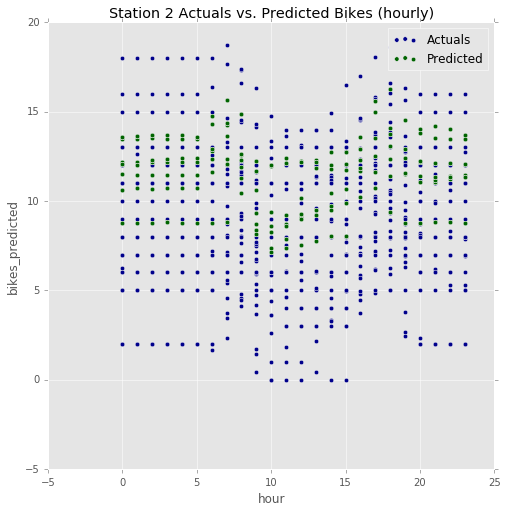

In [27]:
rcParams['figure.figsize'] = 8, 8
ax = station_two.plot.scatter(x='hour', y='bikes_actual', color='DarkBlue', label='Actuals')
station_two.plot.scatter(x='hour', y='bikes_predicted', color='DarkGreen', label='Predicted', ax=ax, title = "Station 2 Actuals vs. Predicted Bikes (hourly)")

This captures central tendancy, but not a strong predictor of the variance of hourly times across the days of the month. 

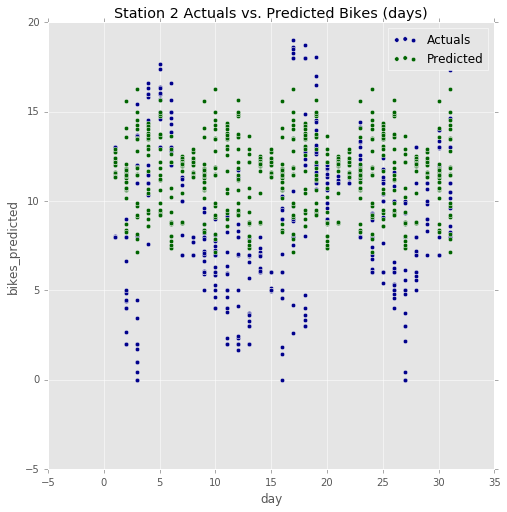

In [28]:
rcParams['figure.figsize'] = 8, 8
ax = station_two.plot.scatter(x='day', y='bikes_actual', color='DarkBlue', label='Actuals')
station_two.plot.scatter(x='day', y='bikes_predicted', color='DarkGreen', label='Predicted', ax=ax, title = "Station 2 Actuals vs. Predicted Bikes (days)")

Once again, this charts the central tendancy, but doesn't give us an accurate picture across the hours of the day. For instance, there are predictions for days 2 and 3 that would be greatly overestimating. 

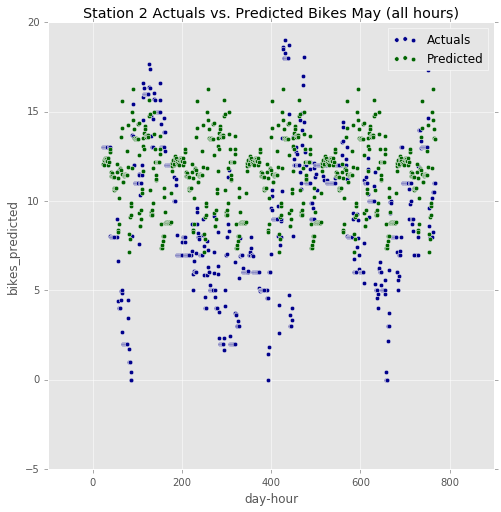

In [29]:
rcParams['figure.figsize'] = 8, 8
ax = station_two.plot.scatter(x='day-hour', y='bikes_actual', color='DarkBlue', label='Actuals')
station_two.plot.scatter(x='day-hour', y='bikes_predicted', color='DarkGreen', label='Predicted', ax=ax, title = "Station 2 Actuals vs. Predicted Bikes May (all hours)")

Let's compare one day at the top 3 stations (see EDA for details on how this was calculated).

* Station 50: Ferry Building
* Station 69: Caltrain (330 Townsend)
* Station 70: Caltrain (Townsend & 4th)

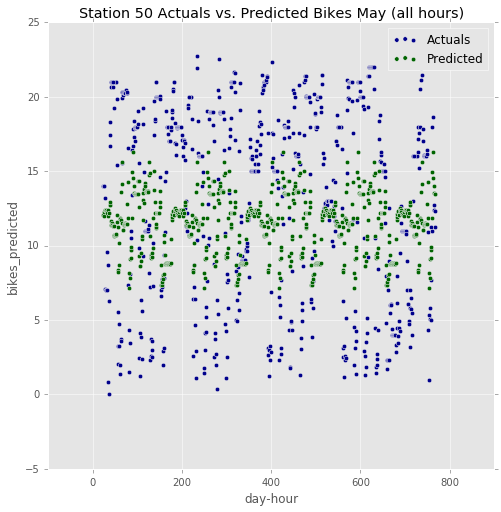

In [30]:
station_fifty = merged_df.query("station_id == 50")
rcParams['figure.figsize'] =  8, 8
ax = station_fifty.plot.scatter(x='day-hour', y='bikes_actual', color='DarkBlue', label='Actuals')
station_two.plot.scatter(x='day-hour', y='bikes_predicted', color='DarkGreen', label='Predicted', ax=ax, title = "Station 50 Actuals vs. Predicted Bikes May (all hours)")

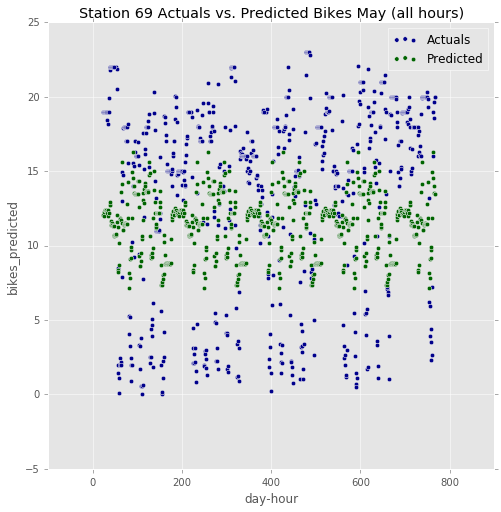

In [31]:
station_sixty_nine = merged_df.query("station_id == 69")
rcParams['figure.figsize'] =  8, 8
ax = station_sixty_nine.plot.scatter(x='day-hour', y='bikes_actual', color='DarkBlue', label='Actuals')
station_two.plot.scatter(x='day-hour', y='bikes_predicted', color='DarkGreen', label='Predicted', ax=ax, title = "Station 69 Actuals vs. Predicted Bikes May (all hours)")

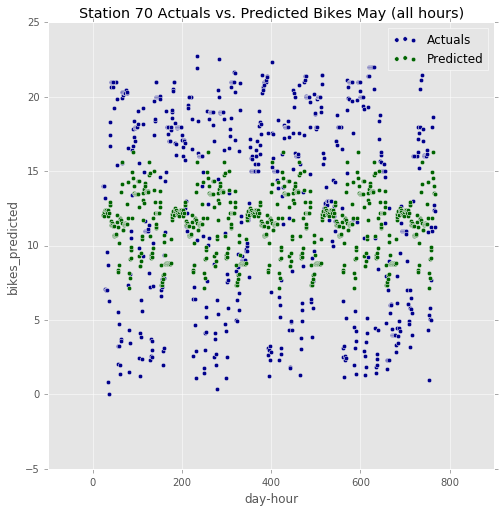

In [32]:
station_seventy = merged_df.query("station_id == 50")
rcParams['figure.figsize'] =  8, 8
ax = station_seventy.plot.scatter(x='day-hour', y='bikes_actual', color='DarkBlue', label='Actuals')
station_two.plot.scatter(x='day-hour', y='bikes_predicted', color='DarkGreen', label='Predicted', ax=ax, title = "Station 70 Actuals vs. Predicted Bikes May (all hours)")

It seems, in general, our predictions are understimating the true variance of our data, which may be a product of our using mean as a central tendency. What if we calculated median?

I compared May predictions for Station 2 using both MEAN and MODE, but saw an increase in mean squared error when using median. 

In [33]:
station_seventy_day_one = station_seventy.query("day == 1")

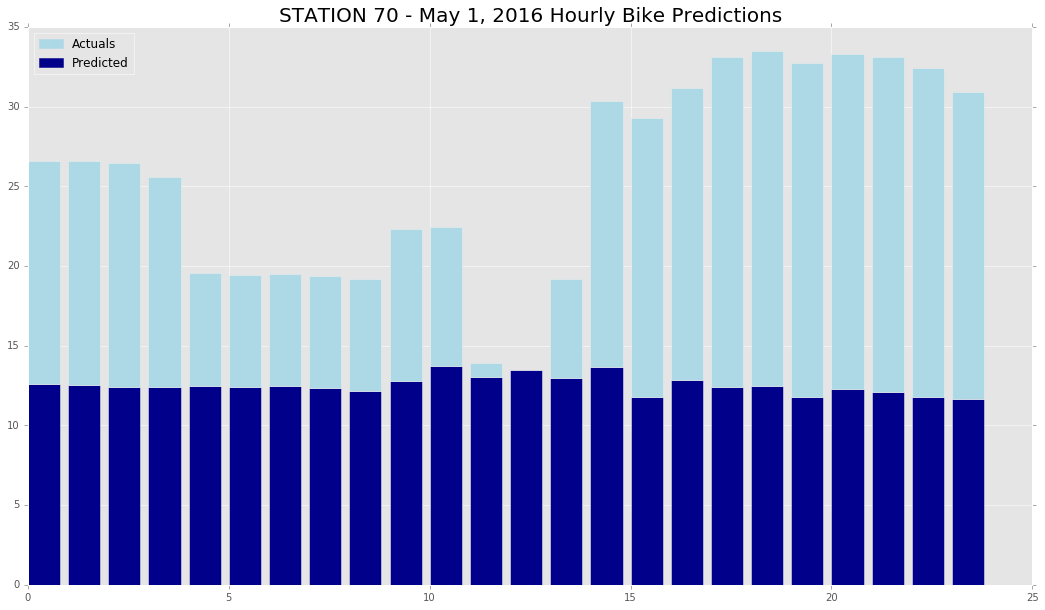

In [34]:
rcParams['figure.figsize'] =  18, 10
# station_seventy_day_one.plot.bar(x = "hour", y = "bikes_predicted", stacked=True)

X = station_seventy_day_one['hour']
A = station_seventy_day_one['bikes_predicted']
B = station_seventy_day_one['bikes_actual']

plt.bar(X, A, color = 'darkblue')
plt.bar(X, B, color = 'lightblue', bottom = A)
plt.title("STATION 70 - May 1, 2016 Hourly Bike Predictions", fontsize=20)

import matplotlib.patches as mpatches

actual = mpatches.Patch(color='lightblue', label='Actuals')
predicted = mpatches.Patch(color='darkblue', label='Predicted')
plt.legend(handles=[actual, predicted], loc=2)


In [35]:
station_seventy_day_two = station_seventy.query("day == 2")

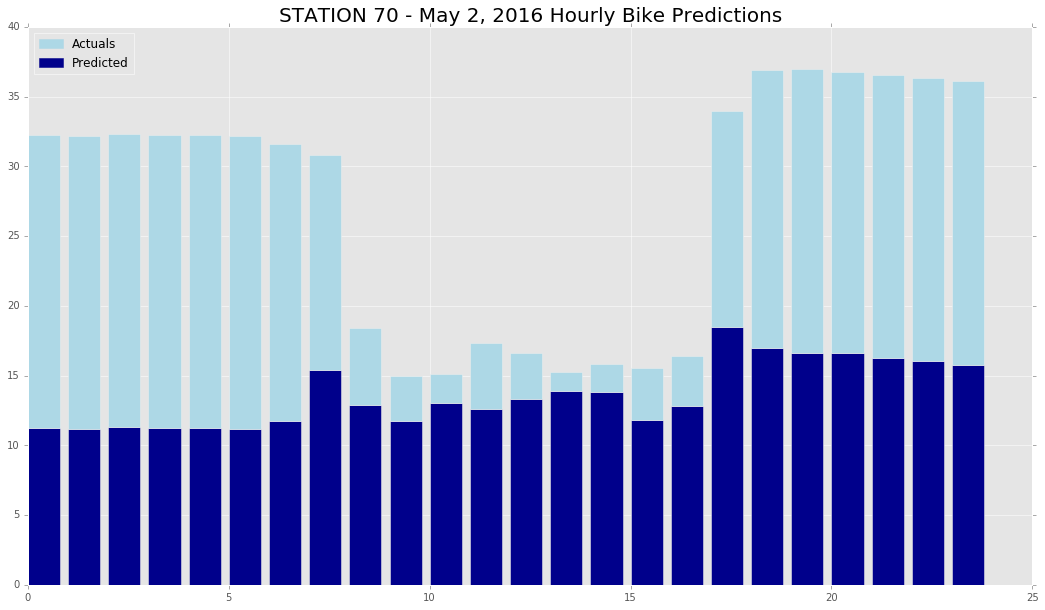

In [36]:
rcParams['figure.figsize'] =  18, 10

X = station_seventy_day_two['hour']
A = station_seventy_day_two['bikes_predicted']
B = station_seventy_day_two['bikes_actual']

plt.bar(X, A, color = 'darkblue')
plt.bar(X, B, color = 'lightblue', bottom = A)
plt.title("STATION 70 - May 2, 2016 Hourly Bike Predictions", fontsize=20)

import matplotlib.patches as mpatches

actual = mpatches.Patch(color='lightblue', label='Actuals')
predicted = mpatches.Patch(color='darkblue', label='Predicted')
plt.legend(handles=[actual, predicted], loc=2)


I wonder what we are losting as we take averages across the days of the week from the 2015 data. Perhaps, overall, we'd get something a bit more accurate if we compared historic data directly (lining up the days of the week - i.e. first mondays of may, etc.)? My sense is that there is enough unique variance across days within a year (and across years), and that such a pinpointed historical estimate would not be that useful, so for the time being we will move on to building models that take into account network state information closer to the target date (in the same year, and perhaps even in the same day). 

# Validation - Station 2 (May)

### Historical means by weekday type

In [52]:
from sklearn.metrics import mean_squared_error
y_true = station_two['bikes_actual']
y_pred = station_two['bikes_predicted']
print "Station 2 (May) MEAN - Mean Squared Error:", mean_squared_error(y_true, y_pred)

 Station 2 (May) MEAN - Mean Squared Error: 22.4605453692


### Historical medians by weekday type

In [53]:
station_two_median = merged_df_median.query("station_id == 2")

In [54]:
y_true = station_two_median['bikes_actual']
y_pred = station_two_median['bikes_predicted']
print "Station 2 (May) MEDIAN - Mean Squared Error:", mean_squared_error(y_true, y_pred)

Station 2 (May) MEDIAN - Mean Squared Error: 25.1431451613


# Validation - All stations (May) 

In [ ]:
def calculate_mean_squared_error(data, n):
    errors = {}
    for i in range(0,n):
        test = data.query("station_id == @i")
        true = test['bikes_actual']
        predicted = test['bikes_predicted']
        errors[i] = mean_squared_error(true, predicted)
    return errors

In [ ]:
# calculate_mean_squared_error(merged_df, 82)

# Validation - All stations all months

In [ ]:
status_full_data_2015 = pd.read_csv('~/Code/bikesupply/data/test_data/_________', parse_dates = ['time'])
status_full_data_2016 = pd.read_csv('~/Code/bikesupply/data/test_data/_________', parse_dates = ['time'])